In [8]:
from sklearn.linear_model import LinearRegression as lr
from sklearn.preprocessing import StandardScaler as ss
from sklearn import metrics
import pandas as pd
import json
from dbanalysis import stop_tools
routes = json.loads(open('/home/student/dbanalysis/dbanalysis/resources/trimmed_routes.json','r').read())
route = routes['130'][0]
models = []
scalers = []
all_dummies = []

In [9]:
len(route)

37

## With neural networks

In [10]:
from sklearn.neural_network import MLPRegressor as mlp
from sklearn.preprocessing import StandardScaler as ss
features = ['rain','temp','day','hour']
y_scalers=[]
from sklearn.preprocessing import MinMaxScaler as mms
route=routes['130'][0]
for i in range(1,len(route)-1):
    stopA = str(route[i])
    stopB = str(route[i+1])
    print('Building for',stopA,'to',stopB)

    df = stop_tools.stop_data(stopA,stopB)
    df = df[df['traveltime']>df['traveltime'].quantile(0.05)]
    test = df[df['year']==2017]
    df = df[df['year']==2016]
    df['traveltime'] = df['actualtime_arr_to'] - df['actualtime_arr_from']
    
    scaler = ss()
    X = scaler.fit_transform(df[features])
    y_scaler = ss()
    Y = y_scaler.fit_transform(df['traveltime'].values.reshape(-1,1))
    model = mlp().fit(X,Y)
    preds = model.predict(scaler.transform(test[features]))
    preds = y_scaler.inverse_transform(preds)
    from sklearn import metrics
    print('model for:',stopA,'to',stopB)
    print('min pred:',preds.min())
    print('mean pred:',preds.mean())
    print('max pred:',preds.max())
    print('Mape:',((abs(test['traveltime']-preds)/test['traveltime'])*100).mean())
    print('r2:',metrics.r2_score(test['traveltime'],preds))
    print('mae:',metrics.mean_absolute_error(test['traveltime'],preds),'\n\n')
    models.append(model)
    scalers.append(scaler)
    y_scalers.append(y_scaler)
    del(df)


Building for 7591 to 496


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model for: 7591 to 496
min pred: 61.703097347296
mean pred: 109.3215298051486
max pred: 134.8650592682286
Mape: 43.903091096554896
r2: 0.028328881196520883
mae: 46.94214963883124 


Building for 496 to 515


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


model for: 496 to 515
min pred: -1355.1417262735658
mean pred: 99.88282685159456
max pred: 329.850606397962
Mape: 62.859068090174866
r2: -4.251598232360193
mae: 91.87590957446439 


Building for 515 to 516
model for: 515 to 516
min pred: 48.95339885850649
mean pred: 67.91703577212886
max pred: 78.93017451669726
Mape: 37.15255988153054
r2: 0.03749409797757208
mae: 20.23375851894947 


Building for 516 to 4384
model for: 516 to 4384
min pred: 32.88008509664275
mean pred: 49.24992164579861
max pred: 63.82541446677799
Mape: 33.71355597589973
r2: -0.06298154619070306
mae: 19.943486492469148 


Building for 4384 to 519
model for: 4384 to 519
min pred: 43.91870266868681
mean pred: 59.744206966083496
max pred: 70.99800441892503
Mape: 25.777928381436862
r2: 0.05530547411909714
mae: 13.700944887044988 


Building for 519 to 521
model for: 519 to 521
min pred: 27.108416917169833
mean pred: 37.80344324403826
max pred: 47.75416427653709
Mape: 49.34918471487737
r2: 0.05906560895273105
mae: 16.226887

In [32]:
import pickle
with open('/data/chainedneuralmodels.bin','rb') as handle:
   
    d=pickle.load(handle)
models = d['models']
scalers = d['x-scalers']
y_scalers = d['y-scalers']

In [11]:
def get_merged(stop):
    route = routes['130'][0][1:]
    begins = stop_tools.stop_data(str(route[0]),str(route[1]))
    begins = begins[begins['year']==2017]
    ends = stop_tools.stop_data(str(route[int(stop)]),str(route[int(stop)+1]))
    ends = ends[ends['year']==2017]
    ends['end'] = ends['actualtime_arr_to']
    
    merged = pd.merge(begins,ends[['tripid','dayofservice','routeid','end']], on=['tripid','dayofservice','routeid'])
    merged = merged[merged['traveltime']>0]
    return merged

In [12]:
def run_to_stop(number,verbose=True):
    features = ['rain','temp','day','hour']
    import copy
    global route
    stop = str(route[number])
    index = 0
    merged = get_merged(number)
    df = copy.deepcopy(merged)
    for i,model in enumerate(models):
        
        index+=1
        cur_stop = route[index]
        if cur_stop == route[number+1]:
            break
        X=copy.deepcopy(df[features])
        X = scalers[i].transform(X)
        traveltime = model.predict(X)
        traveltime = y_scalers[i].inverse_transform(traveltime)
        #print(traveltime.mean())
        df['actualtime_arr_from'] = df['actualtime_arr_from'] + traveltime
        df = df[[i for i in df.columns if i[0:4] != 'hour']]
        df['hour'] = (df['actualtime_arr_from'] //3600).astype('int64')
        #arr.append(copy.deepcopy(df))

        
    real_traveltimes = merged['end'] - merged['actualtime_arr_from']

    pred_traveltimes = df['actualtime_arr_from'] - merged['actualtime_arr_from']
    if verbose:
        print(df['actualtime_arr_from'].mean())
        print('MAE:',metrics.mean_absolute_error(real_traveltimes,pred_traveltimes))
        print('MAPE:',((abs(real_traveltimes-pred_traveltimes)/real_traveltimes)*100).mean())
        print('r2:',metrics.r2_score(real_traveltimes,pred_traveltimes))
    return metrics.r2_score(real_traveltimes,pred_traveltimes),((abs(real_traveltimes-pred_traveltimes)/real_traveltimes)*100).mean()

In [15]:
MAPES = []
r2s = []
import time
t = time.time()
for i in range(1,35):
    print(i)
    r2,MAPE = run_to_stop(i,verbose=False)
    r2s.append(r2)
    MAPES.append(MAPE)
print(time.time()-t)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
85.73310256004333


In [16]:
sum(MAPES)/len(MAPES)

19.584270273777165

In [ ]:
min(MAPES)

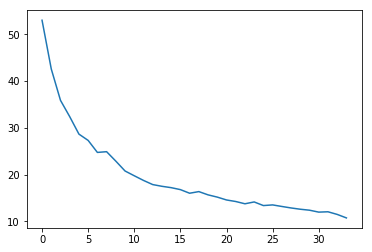

In [18]:
from matplotlib import pyplot as plt
plt.plot(range(len(MAPES)),MAPES)
plt.show()

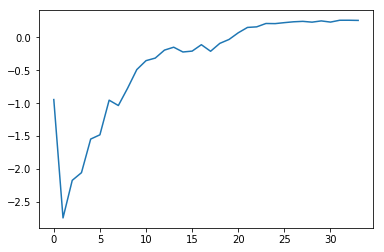

In [19]:
from matplotlib import pyplot as plt
plt.plot(range(len(r2s)),r2s)


In [20]:
max(r2s)

0.2595316020609715

-0.5894347329251236

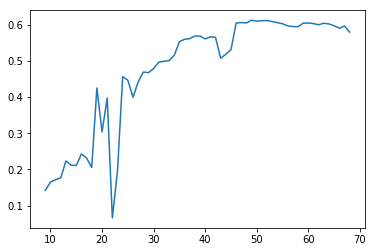

In [21]:
from matplotlib import pyplot as plt
plt.plot(range(9,69),r2s[8:])


In [13]:
max(r2s)

0.5167369239106632

In [17]:
r2s

[-2.3243963800559464,
 -5.122852718987301,
 -1.466225453086044,
 -0.9765732214368865,
 0.04131244740870532,
 -0.05741087802918754,
 -0.21335463841355584,
 -0.044777395479644655,
 0.020514438062677054,
 0.14775545095191123,
 -0.09843726146392595,
 0.0903747652054614,
 0.28604008081344,
 0.20765217756066245,
 0.2723283514588516,
 0.22319049829180637,
 0.2451910419534553,
 0.21236341277763426,
 0.30161277569223943,
 0.3465129756070603,
 0.35254771477960267,
 0.27478340419172265,
 0.2625933693915301,
 0.3497972083635482,
 0.3397104819858573,
 0.3469183890249389,
 0.36170864252864066,
 0.3260883969942254,
 0.40574149757735134,
 0.3272323686015437,
 -0.1736892263550447,
 -0.39244511728335274,
 0.06570195164843029,
 0.2441273048369964,
 0.25790235342469836,
 0.24597415275739953,
 0.2509308891626172,
 0.34613515806401063,
 0.3695159604058712,
 0.38139908855394056,
 0.3796616107914146,
 0.36876404375336835,
 0.36139120455344076,
 0.37522733502024297,
 0.38243218382087707,
 0.40324094695441537,


In [15]:
max(r2s)

0.47391227923156953

In [ ]:
import pickle
with open('/data/chainedneuralmodels.bin','wb') as handle:
    d= {'models':models,\
       'x-scalers':scalers,\
        'y-scalers':y_scalers}
    pickle.dump(d,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
len(models)

69

A reason not to use these is that these sixty models and scalers pickle to about 6 megabytes. We would need roughly 500-600 megabytes of models in memory then, just to run our time table predictions quickly. Though it is possible we could just load and delete them as needed, the linear models are miniscule in comparison.

They also take much longer to predict than the linear models, (but only slightly), and some still give negative predictions.

Also, an instance can be seen of r2 score sharply plunging at the end of the route. Though I think this is also true for the linear models. The trouble is that, since the training time is so greatly increased, it will be harder to avoid this. Harder than with the liner models anyway.

The r2 scores are significantly better, but the MAPE isn't. The r2 matters to us as data scientists, but it would seem like a) MAPE and b) actually having a working app would be of more concern to the user.






In [25]:
sum(MAPES)/len(MAPES)

12.103629580532802

The Mean MAPE was about 13% for the linear models. They're also much faster.

## On production:

The decision was made to build the neural models and use them in the application, lagely due to the
increased r2 score.

Negative predictions were encountered when the models were deployed into the application. Here they are investigated.


In [1]:
from sklearn.neural_network import MLPRegressor as mlp
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.preprocessing import StandardScaler as ss
import os
import pandas as pd
import pickle
df = pd.DataFrame({'temp':[10],'vappr':[10],'rain':[0.08],'hour':[5],'day':[4]})
to_concat = []
import copy
for day in range(7):
    for hour in range(5,24):
        af = copy.deepcopy(df)
        af['day'] = day
        af['hour'] = hour
        af['actualtime_arr_from'] = hour // 3600
        to_concat.append(af)
df = pd.concat(to_concat,axis=0)
print(df.head(5))
input()
files = os.listdir('/data/neural_models')
negative_count = 0
total_count = 0
for f in files:
    try:
        with open('/data/neural_models/'+f,'rb') as handle:
            d = pickle.load(handle)
    except:
        continue
    handle.close()
    X_scaler = d['X_scaler']
    Y_scaler = d['Y_scaler']


    X = X_scaler.transform(df[['rain','temp','vappr','hour','day']])

    preds = d['model'].predict(X)
    Y = Y_scaler.inverse_transform(preds)
    negative_count += sum(Y<0)
    total_count += Y.shape[0]
    
print(negative_count / total_count)

   temp  vappr  rain  hour  day  actualtime_arr_from
0    10     10  0.08     5    0                    0
0    10     10  0.08     6    0                    0
0    10     10  0.08     7    0                    0
0    10     10  0.08     8    0                    0
0    10     10  0.08     9    0                    0

0.005804054371854569


Almost two percent of the predictions returned negative. This posed numerous problems. The trouble was that negative predictions had a propensity to propagate down the chain. Though they could be offset by imputing the mean  

In [2]:
from sklearn.neural_network import MLPRegressor as mlp
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.preprocessing import StandardScaler as ss
import os
import pandas as pd
import pickle
df = pd.DataFrame({'temp':[10],'vappr':[10],'rain':[0.08],'hour':[5],'day':[4]})

to_concat = []
import copy
for day in range(7):
    for hour in range(5,24):
        af = copy.deepcopy(df)
        af['day'] = day
        af['hour'] = hour
        af['actualtime_arr_from'] = hour // 3600
        to_concat.append(af)

    
df = pd.concat(to_concat,axis=0)
for i in range(2,5):
    df['hour'+str(i)] = df['hour']**i
    df['day'+str(i)] = df['day'] ** i
print(df.head(5))
input()
files = os.listdir('/data/linear_models3')
negative_count = 0
total_count = 0
for f in files:
    try:
        with open('/data/linear_models3/'+f,'rb') as handle:
            model = pickle.load(handle)
    except:
        continue
    handle.close()
    features = ['rain','temp','vappr','hour','hour2','hour3','hour4','day','day2','day3','day4']
    X = df[features]
    Y = model.predict(X)
    
   
    total_count += Y.shape[0]
    negative_count += sum(Y < 0)

print(negative_count / total_count)

   temp  vappr  rain  hour  day  actualtime_arr_from  hour2  day2  hour3  \
0    10     10  0.08     5    0                    0     25     0    125   
0    10     10  0.08     6    0                    0     36     0    216   
0    10     10  0.08     7    0                    0     49     0    343   
0    10     10  0.08     8    0                    0     64     0    512   
0    10     10  0.08     9    0                    0     81     0    729   

   day3  hour4  day4  
0     0    625     0  
0     0   1296     0  
0     0   2401     0  
0     0   4096     0  
0     0   6561     0  

0.015657870721702962


 There were, it seemed, actually more negative predictions for the linear models.

In [15]:
Y[Y > 0]

array([44.56610446, 44.56610446, 44.56610446, 44.56610446, 44.56610446,
       44.56610446, 44.56610446, 44.56610446, 44.56610446, 44.56610446,
       44.56610446, 44.56610446, 44.56610446, 44.56610446, 44.56610446,
       44.56610446, 44.56610446, 44.56610446, 44.56610446, 43.93371241,
       43.93371241, 43.93371241, 43.93371241, 43.93371241, 43.93371241,
       43.93371241, 43.93371241, 43.93371241, 43.93371241, 43.93371241,
       43.93371241, 43.93371241, 43.93371241, 43.93371241, 43.93371241,
       43.93371241, 43.93371241, 43.93371241, 44.40815811, 44.40815811,
       44.40815811, 44.40815811, 44.40815811, 44.40815811, 44.40815811,
       44.40815811, 44.40815811, 44.40815811, 44.40815811, 44.40815811,
       44.40815811, 44.40815811, 44.40815811, 44.40815811, 44.40815811,
       44.40815811, 44.40815811, 44.61983034, 44.61983034, 44.61983034,
       44.61983034, 44.61983034, 44.61983034, 44.61983034, 44.61983034,
       44.61983034, 44.61983034, 44.61983034, 44.61983034, 44.61

In [16]:
m = Y[Y>0].mean()

In [17]:
m

43.5907302504894

In [20]:
Y[Y<0].mean()

-1.0

In [21]:
Y[Y<0] = m

In [19]:
Y[0] = -1

In [22]:
Y[0]

43.5907302504894

In [23]:
Y


array([43.59073025, 44.56610446, 44.56610446, 44.56610446, 44.56610446,
       44.56610446, 44.56610446, 44.56610446, 44.56610446, 44.56610446,
       44.56610446, 44.56610446, 44.56610446, 44.56610446, 44.56610446,
       44.56610446, 44.56610446, 44.56610446, 44.56610446, 43.93371241,
       43.93371241, 43.93371241, 43.93371241, 43.93371241, 43.93371241,
       43.93371241, 43.93371241, 43.93371241, 43.93371241, 43.93371241,
       43.93371241, 43.93371241, 43.93371241, 43.93371241, 43.93371241,
       43.93371241, 43.93371241, 43.93371241, 44.40815811, 44.40815811,
       44.40815811, 44.40815811, 44.40815811, 44.40815811, 44.40815811,
       44.40815811, 44.40815811, 44.40815811, 44.40815811, 44.40815811,
       44.40815811, 44.40815811, 44.40815811, 44.40815811, 44.40815811,
       44.40815811, 44.40815811, 44.61983034, 44.61983034, 44.61983034,
       44.61983034, 44.61983034, 44.61983034, 44.61983034, 44.61983034,
       44.61983034, 44.61983034, 44.61983034, 44.61983034, 44.61

# Comparing this with the big route model .

Big route model had a higher MAPE, overall. 15% for the entire route. The chained models manage 12 %.

Big route model is very, very bad at the start, and then quite good, though it does suffer a drop in r2 score in the middle. The chained models are bad at the start, and then bad again in the middle, though I don't feel like they are _quite_ as bad overall.

The big route model gives negative scores, and there is no actual certainty that it won't predict that distance X+1 takes less time than distance X.

The chained models also give negative scores, but they can be corrected easier. 

There are only five days left, but maybe the solution is to deliver both. I don't feel that either is particularly good, but I honestly can't decide between them.

I like the chained models better because it's easier to understand what they're doing, and they don't seem to automatically learn negatives for the beginning of their curves.

There is also the strong positive that they don't rely on dummies etc. In addition, it is easier to use them to impute the missing values and thus build the whole network.